# Lightning Faces GAN
This notebook trains the same face GAN in the other notebook, except it is built using the Pytorch Lightning framework. This allows for easy training with `.train()`, similar to Tensorflow.

Following the documentation/tutorial on the [Lightning docs](https://pytorch-lightning.readthedocs.io/en/stable/notebooks/lightning_examples/basic-gan.html), we'll define our generator and discriminator as separate modules, like the previous module, and adjust the `training_step()` method in the `LightningModule` to define how to backpropagate the losses in both models.

## Import Packages
The same packages as last time, with Pytorch Lightning.

In [1]:
import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

seed = 1729
print('Random Seed:', seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed: 1729


## Configuration
Same configuration as last time, set all the variables we plan to use, including the location of the data path.

In [2]:
# Root directory for dataset
dataroot = "./Data/celeba"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Lightning Data Module
Instead of a raw `DataLoader` like before, we'll use PyTorch Lightning's own `DataLoader`. For a GAN, we don't need validation or test datasets.

In [3]:
class FacesDataModule(LightningDataModule):
    def __init__(self, data_root, image_size, batch_size, num_workers):
        super().__init__()
        self.faces_train = None
        self.data_root = data_root
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transforms = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self) -> None:
        self.faces_train = dset.ImageFolder(root=self.data_root,
                                            transform=self.transforms)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.faces_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

## Generator and Disrciminator Modules
For defining each neural network, we will use two separate modules. These will be directly `nn.Module`, so these themselves do not have anything to do with PyTorch Lightning.
### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

### Discriminator
Same thing for the discriminator. A simple init and forward methods.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Initialization Method
A quick method to initialize the two nets. This will be used in the entire module.

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## GAN creation
Here is where we actually create the entire GAN, with both the generator and discriminator in the initialization.

In [17]:
class GAN(LightningModule):
    def __init__(self, lr, beta1, beta2=0.999, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        # Create the generator and discriminator and
        # initialize the layers
        self.generator = Generator(nz, ngf, nc, ngpu).to(device)
        self.generator.apply(weights_init)
        self.discriminator = Discriminator(nc, ndf, ngpu).to(device)
        self.discriminator.apply(weights_init)

        self.real_label = 1.
        self.fake_label = 0.

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        lr = self.hparams.lr
        beta1 = self.hparams.beta1
        beta2 = self.hparams.beta2

        optimizerG = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, beta2))
        optimizerD = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, beta2))
        return [optimizerG, optimizerD], []

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch
        b_size = imgs.size(0)
        # sample noise
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Train generator, maximize log(D(G(z)))
        if optimizer_idx == 0:
            # Generate "real" image batch with G
            # label.fill_(self.fake_label)
            # For purposes of generator, the target needs to be real,
            # because the generator is trying to trick the discriminator.
            label = torch.full((b_size,), self.real_label, dtype=torch.float).to(device)
            # We call the discriminator on the generated output
            output = self.discriminator(self(noise)).view(-1)
            # Calculate loss and return
            g_loss = self.adversarial_loss(output, label)
            self.log('G_loss', g_loss, prog_bar=True)
            return g_loss

        # Train discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        if optimizer_idx == 1:
            # label.fill_(self.real_label)
            label = torch.full((b_size,), self.real_label, dtype=torch.float).to(device)
            # Calculate loss for real images
            real_loss = self.adversarial_loss(self.discriminator(imgs).view(-1), label)

            # Now run fake images through = images that are generated
            label = torch.full((b_size,), self.fake_label, dtype=torch.float).to(device)
            fake_loss = self.adversarial_loss(self.discriminator(self(noise).detach()).view(-1), label)

            # Discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            self.log('D_loss', d_loss, prog_bar=True)
            return d_loss


## Training

In [18]:
dm = FacesDataModule(dataroot, image_size, batch_size, workers)
model = GAN(lr, beta1)

In [19]:
trainer = Trainer(
    accelerator='auto',
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=5,
    callbacks=[TQDMProgressBar(refresh_rate=20)]
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3.6 M 
1 | discriminator | Discriminator | 2.8 M 
------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)
C:\Users\mughi\miniconda3\envs\pytorch_suite\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [20]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
model.to(device)
fake_images = model(fixed_noise).detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


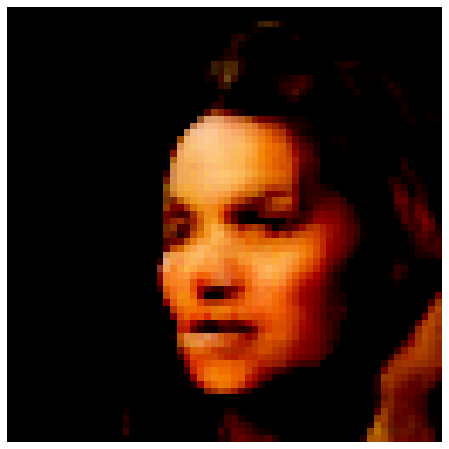

In [22]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(fake_images[0], (1, 2, 0)))